# Provisioning a Cassandra Database

Right out of the box we now how to capacity plan Cassandra

In [1]:
from service_capacity_modeling.interface import CapacityDesires
from service_capacity_modeling.interface import FixedInterval, Interval
from service_capacity_modeling.interface import QueryPattern, DataShape

db_desires = CapacityDesires(
    # This service is important to the business, not critical (tier 0)
    service_tier=1,
    query_pattern=QueryPattern(
        # Not sure exactly how much QPS we will do, but we think around
        # 10,000 reads and 10,000 writes per second.
        estimated_read_per_second=Interval(
            low=1000, mid=10000, high=100000, confidence=0.9
        ),
        estimated_write_per_second=Interval(
            low=1000, mid=10000, high=100000, confidence=0.9
        ),
    ),
    # Not sure how much data, but we think it'll be below 1 TiB
    data_shape=DataShape(
        estimated_state_size_gib=Interval(low=100, mid=500, high=1000, confidence=0.9),
    ),
)

In [2]:
from service_capacity_modeling.capacity_planner import planner
from service_capacity_modeling.models.org import netflix

# Load up the Netflix capacity models
planner.register_group(netflix.models)

cap_plan = planner.plan(
    model_name="org.netflix.cassandra",
    region="us-east-1",
    desires=db_desires,
    allow_gp2=True,
)

import pprint
def mprint(x):
    pprint.pprint(x.dict(exclude_unset=True), sort_dicts=False)

Loading aws from /home/jolynch/pg/service-capacity-modeling/service_capacity_modeling/hardware/profiles/shapes/aws
Loading /home/jolynch/pg/service-capacity-modeling/service_capacity_modeling/hardware/profiles/pricing/aws/3yr-reserved.json


# An uncertain Capacity plan has a few elements

* `requirement`: The range of requirements
* `least_regret`: The clusters which minimized the models regret function over many simulations.
* `mean`: The clusters that would be provisioned for the average (midpoint) of all intervals.
* `percentiles`: The clusters that would be provisioned assuming various percentiles of the inputs (can use this to generate a "worse case" estimate)

In [3]:
requirement = cap_plan.requirement

lr_opt1, lr_opt1_cost = (
    cap_plan.least_regret[0].candidate_clusters.zonal[0],
    cap_plan.least_regret[0].candidate_clusters.total_annual_cost
)
lr_opt2, lr_opt2_cost = (
    cap_plan.least_regret[1].candidate_clusters.zonal[0],
    cap_plan.least_regret[1].candidate_clusters.total_annual_cost
)
mean_opt, mean_cost = (
    cap_plan.mean[0].candidate_clusters.zonal[0],
    cap_plan.mean[0].candidate_clusters.total_annual_cost
)

In [4]:
mprint(requirement)

{'core_reference_ghz': 2.3,
 'cpu_cores': {'low': 2.0,
               'mid': 13.0,
               'high': 68.0,
               'confidence': 0.9,
               'minimum_value': 1.0,
               'maximum_value': 132.0},
 'mem_gib': {'low': 19.0,
             'mid': 108.0,
             'high': 391.0,
             'confidence': 0.9,
             'minimum_value': 16.0,
             'maximum_value': 699.0},
 'network_mbps': {'low': 10.0,
                  'mid': 124.0,
                  'high': 862.0,
                  'confidence': 0.9,
                  'minimum_value': 4.0,
                  'maximum_value': 2180.0},
 'disk_gib': {'low': 67.0,
              'mid': 364.0,
              'high': 1319.0,
              'confidence': 0.9,
              'minimum_value': 55.0,
              'maximum_value': 2358.0}}


In [5]:
print("Cluster:",); mprint(lr_opt1)
print("Cost:",); mprint(lr_opt1_cost)

Cluster:
{'cluster_type': 'cassandra',
 'count': 4,
 'instance': {'name': 'r5.2xlarge',
              'cpu': 8,
              'cpu_ghz': 3.1,
              'ram_gib': 64.0,
              'net_mbps': 2000.0,
              'drive': None,
              'annual_cost': 1660.0},
 'attached_drives': [{'name': 'gp2',
                      'size_gib': 300,
                      'annual_cost_per_gib': 1.2,
                      'annual_cost_per_read_io': 0,
                      'annual_cost_per_write_io': 0,
                      'read_io_latency_ms': {'low': 0.4,
                                             'mid': 0.6,
                                             'high': 2.0,
                                             'confidence': 0.98},
                      'write_io_latency_ms': {'low': 0.5,
                                              'mid': 1.0,
                                              'high': 5.0,
                                              'confidence': 0.98}}],
 'annual_cost

In [6]:
print("Cluster:",); mprint(lr_opt2)
print("Cost:",); mprint(lr_opt2_cost)

Cluster:
{'cluster_type': 'cassandra',
 'count': 1,
 'instance': {'name': 'r5d.8xlarge',
              'cpu': 32,
              'cpu_ghz': 3.1,
              'ram_gib': 256.0,
              'net_mbps': 10000.0,
              'drive': {'name': 'ephem',
                        'size_gib': 1200,
                        'read_io_latency_ms': {'low': 0.2,
                                               'mid': 0.3,
                                               'high': 1.0,
                                               'confidence': 0.98}},
              'annual_cost': 7588.0},
 'attached_drives': [],
 'annual_cost': 7588.0}
Cost:
{'low': 22764.0, 'mid': 22764.0, 'high': 22764.0, 'confidence': 1.0}


In [7]:
mprint(mean_opt)
mprint(mean_cost)

{'cluster_type': 'cassandra',
 'count': 2,
 'instance': {'name': 'm5.2xlarge',
              'cpu': 8,
              'cpu_ghz': 3.1,
              'ram_gib': 32.0,
              'net_mbps': 2000.0,
              'drive': None,
              'annual_cost': 1264.6},
 'attached_drives': [{'name': 'gp2',
                      'size_gib': 600,
                      'annual_cost_per_gib': 1.2,
                      'annual_cost_per_read_io': 0,
                      'annual_cost_per_write_io': 0,
                      'read_io_latency_ms': {'low': 0.4,
                                             'mid': 0.6,
                                             'high': 2.0,
                                             'confidence': 0.98},
                      'write_io_latency_ms': {'low': 0.5,
                                              'mid': 1.0,
                                              'high': 5.0,
                                              'confidence': 0.98}}],
 'annual_cost': 3249.2

# Modeling Intervals
The key to the capacity planner is going from intervals such as `my RPS will be within an order of magnitude of 10,000 per second` to a generative probability distribution that is skewed. We represent these with `Intervals` which have a `low`, `mid` and `high`. For example:

```
rps = Interval(low=1_000, mid=10_000, high=100_000, confidence=0.9)
```

Under the hood we do this by solving a numerical set of equations for the [gamma](https://en.wikipedia.org/wiki/Gamma_distribution#:~:text=The%20gamma%20distribution%20is%20the,%CF%88%20is%20the%20digamma%20function) distribution and fitting to the summary statistics.

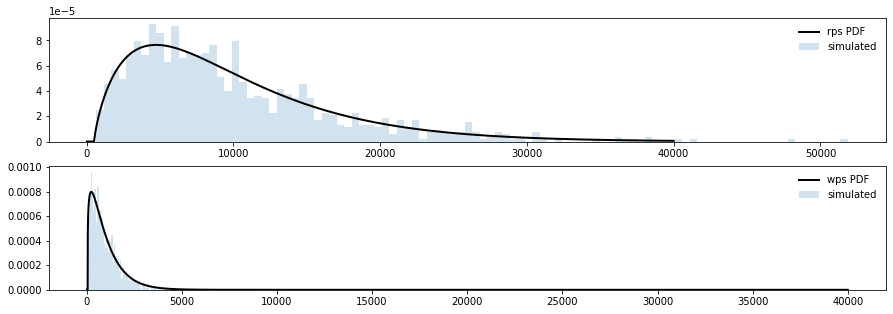

In [8]:
from service_capacity_modeling.stats import gamma_for_interval
import matplotlib.pyplot as plt
import numpy as np

rps = Interval(low=1_000, mid=10_000, high=100_000, confidence=0.9)
wps = Interval(low=100, mid=1_000, high=2_000, confidence=0.9)

rps_gamma = gamma_for_interval(rps)
wps_gamma = gamma_for_interval(wps)


fig, ax = plt.subplots(2, 1, figsize=(15,5))
ax[0].ticklabel_format(useOffset=False)

x = np.linspace(10, 40_000, 10000)

# First RPS
ax[0].plot(x, rps_gamma.pdf(x), 'k-', lw=2, label='rps PDF')

r = rps_gamma.rvs(size=1028)
ax[0].hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=100, label="simulated")
ax[0].legend(loc='best', frameon=False)

# Now WPS
ax[1].plot(x, wps_gamma.pdf(x), 'k-', lw=2, label='wps PDF')

r = wps_gamma.rvs(size=1028)
ax[1].hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=100, label="simulated")
ax[1].legend(loc='best', frameon=False)

plt.show()

# Key Insight: Skew Matters

Physical processes skew left and skew right, and we need to be able to represent that. Luckily we can!

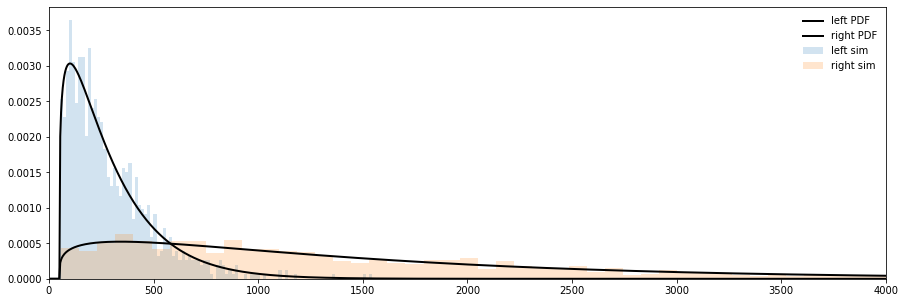

In [9]:
left_skew = Interval(low=100, mid=300, high=2000, confidence=0.9)
right_skew = Interval(low=100, mid=1500, high=2000, confidence=0.9)

left_gamma = gamma_for_interval(left_skew)
right_gamma = gamma_for_interval(right_skew)

fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(10, 4000, 1000)

# Now right skew
ax.plot(x, left_gamma.pdf(x), 'k-', lw=2, label='left PDF')
ax.plot(x, right_gamma.pdf(x), 'k-', lw=2, label='right PDF')

ax.hist(left_gamma.rvs(size=1028), density=True, histtype='stepfilled', alpha=0.2, bins=100, label="left sim")
ax.hist(right_gamma.rvs(size=1028), density=True, histtype='stepfilled', alpha=0.2, bins=100, label="right sim")

ax.legend(loc='best', frameon=False)
ax.set_xlim(0.0, 4000)

plt.show()

We can actually use this to approximate all manner of Hardware properties such as:

* On CPU time of operations (e.g. some reads are slower than others)
* Request size distributions (e.g. some reads are bigger than others)
* Disk latency (e.g. some disks are faster or more consistent than others)

For a concrete example let's model a m5d drive which we [model](https://github.com/Netflix-Skunkworks/service-capacity-modeling/blob/dd1fb503b4505327d1cf14d2d614c0e796bb8f05/service_capacity_modeling/hardware/profiles/shapes/aws.json#L98) with an io latency distribution. Data for comparision comes from using `biosnoop` and [`histogram.py`](https://github.com/bitly/data_hacks/blob/master/data_hacks/histogram.py)

```bash
$ sudo /usr/share/bcc/tools/biosnoop > ios
$ grep SharedPool ios | tr -s ' ' | cut -f 8  -d ' ' > io_lat
$ cat io_lat | histogram.py -l -p
# NumSamples = 107517; Min = 0.06; Max = 2.43
# Mean = 0.118898; Variance = 0.002304; SD = 0.048005; Median 0.100000
# each ∎ represents a count of 569
    0.0600 -     0.0623 [    94]:  (0.09%)
    0.0623 -     0.0670 [     0]:  (0.00%)
    0.0670 -     0.0762 [   505]:  (0.47%)
    0.0762 -     0.0948 [ 33459]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (31.12%)
    0.0948 -     0.1318 [ 42706]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (39.72%)
    0.1318 -     0.2060 [ 29154]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (27.12%)
    0.2060 -     0.3542 [   994]: ∎ (0.92%)
    0.3542 -     0.6508 [   523]:  (0.49%)
    0.6508 -     1.2438 [    77]:  (0.07%)
    1.2438 -     2.4300 [     5]:  (0.00%)
```


In [10]:
real_data = np.loadtxt("io_lat")
real_interval = np.percentile(real_data, [1, 50, 99])
print(f"{real_interval} with range [{min(real_data)}, {max(real_data)}]")

read_io_latency = FixedInterval(low=0.08, mid=0.1, high=0.24, confidence=0.98)
io_gamma = gamma_for_interval(read_io_latency)

[0.08 0.1  0.24] with range [0.06, 2.43]


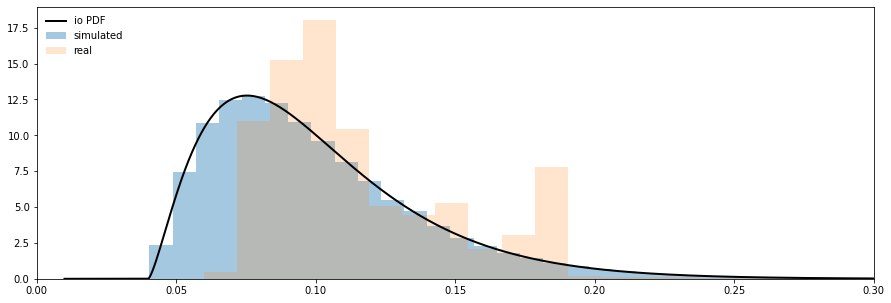

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(0.01, 0.3, 10000)

ax.plot(x, io_gamma.pdf(x), 'k-', lw=2, label='io PDF')

r = io_gamma.rvs(size=len(real_data))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=50, label="simulated")
ax.hist(real_data, density=True, histtype='stepfilled', bins=200, alpha=0.2, label="real")

ax.legend(loc='best', frameon=False)
ax.set_xlim(0.0, 0.3)

plt.show()

In [12]:
from scipy.stats import kstest
print(kstest(r, real_data))

KstestResult(statistic=0.35001906675223454, pvalue=0.0)
